<a href="https://colab.research.google.com/github/NHCh1/DLI/blob/main/DLI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [38]:
import numpy as np
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# Data Loading

In [24]:
url = 'https://raw.githubusercontent.com/NHCh1/DLI/refs/heads/main/Dli-mendeley_18.csv'
data = pd.read_csv(url, header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,1,1,50,0,0,0,0,0,0,...,0,0,0,1,1,-1,1,0,1,0
9996,2,1,4,59,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
9997,2,1,4,57,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
9998,3,1,1,49,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


# Pre-processing

In [25]:
#Array of features
x = data.drop([48], axis=1)
print(x)

#Array of target
y = data[48]
print(y)

      0   1   2    3   4   5   6   7   8   9   ...  38  39  40  41  42  43  \
0      3   1   5   72   0   0   0   0   0   0  ...   0   0   0   1   1   0   
1      3   1   3  144   0   0   0   0   2   0  ...   0   0   0   0   1  -1   
2      3   1   2   58   0   0   0   0   0   0  ...   0   0   0   0   1   0   
3      3   1   6   79   1   0   0   0   0   0  ...   1   0   0   0   1  -1   
4      3   0   4   46   0   0   0   0   0   0  ...   0   1   0   0   1   1   
...   ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
9995   3   1   1   50   0   0   0   0   0   0  ...   0   0   0   0   1   1   
9996   2   1   4   59   1   0   0   0   0   0  ...   0   1   0   0   1   0   
9997   2   1   4   57   0   0   0   0   0   0  ...   0   0   0   0   1   0   
9998   3   1   1   49   0   0   0   0   0   0  ...   0   1   0   0   1   1   
9999   3   1   2   52   3   0   0   0   0   0  ...   0   0   0   0   1   1   

      44  45  46  47  
0      1   1  -1   1  
1      1   1   1 

In [ ]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [ ]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

print(x_train)
print('------------------------------------------------------------------')
print(x_test)

# XGBoost - Liong Chi Teng - TP065355

Defining XGBoost Model

In [ ]:
xgb_basic = XGBClassifier(eval_metric='error',
                          use_label_encoder=False,
                          n_jobs=-1,
                          random_state=42,
                          verbosity=0
                          )

Performing feature selection in XGBoost

In [ ]:
selector = RFECV(xgb_basic, cv=5, n_jobs=-1)
selector.fit(x, y)

selected_cols = np.where(selector.ranking_ == 1)[0]
print(f"Selected feature indices: {selected_cols}")

xgb_pipe = make_pipeline(ColumnSelector(cols=selected_cols),
                         XGBClassifier(eval_metric='error',
                                       use_label_encoder=False,
                                       n_jobs=-1,
                                       random_state=42
                                       )
                         )

xgb_pipe.fit(x_train, y_train)
xgb_pipe_train = xgb_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_pipe_test = xgb_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
xgb_pipe_accuracy = xgb_pipe.score(x_test, y_test)
print(f"Accuracy: {xgb_pipe_accuracy:.8f}")

Finding best hyperparameters and best threshold in XGBoost

In [ ]:
param_dist = {'xgbclassifier__max_depth': [4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
              'xgbclassifier__n_estimators': [1000, 2000, 3000],
              'xgbclassifier__subsample': [0.7, 0.8, 0.9],
              'xgbclassifier__colsample_bytree': [0.7, 0.8, 0.9],
              'xgbclassifier__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]
              }

xgb_search = RandomizedSearchCV(xgb_pipe,
                                param_distributions=param_dist,
                                n_iter=20,
                                cv=5,
                                n_jobs=-1,
                                scoring='accuracy',
                                verbose=1
                                )

xgb_search.fit(x_train, y_train)
print("Best Hyperparameters:", xgb_search.best_params_)

xgb_model = xgb_search.best_estimator_
xgb_probs = xgb_model.predict_proba(x_test)[:, 1]
xgb_model_train = xgb_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
xgb_model_test = xgb_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

thresholds = [i / 100 for i in range(1, 100)]
best_acc, best_thresh = 0, 0

for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc, best_thresh = acc, t

print(f"Best Threshold: {best_thresh:.4f}, Best Accuracy: {best_acc:.8f}")
xgb_final_pred = (xgb_probs >= best_thresh).astype(int)

XGBoost Model Training Result

In [ ]:
xgb_acc     = accuracy_score(y_test, xgb_final_pred)
xgb_prec    = precision_score(y_test, xgb_final_pred)
xgb_rec     = recall_score(y_test, xgb_final_pred)
xgb_f1      = f1_score(y_test, xgb_final_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs)

xgb_pipe_prob = xgb_pipe.predict_proba(x_test)[:, 1]
xgb_pipe_pred = (xgb_pipe_test >= 0.5).astype(int)

print("\nFinal Xgb Model Metrics")
print(f"Accuracy  : {xgb_acc:.4f}")
print(f"Precision : {xgb_prec:.4f}")
print(f"Recall    : {xgb_rec:.4f}")
print(f"F1-score  : {xgb_f1:.4f}")
print(f"ROC-AUC   : {xgb_roc_auc:.4f}")

# CNN Complex - Ng Hooi Chi - TP065587

Reshape data from 2D to 3D

In [ ]:
x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Defining CNN Complex Model

In [ ]:
def cnn_complex_tabular():
    model = Sequential()
    model.add(Input(shape=(48, 1)))
    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 7, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(MaxPooling1D(3, padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='tanh', padding='same'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

cnn_model = cnn_complex_tabular()

Training CNN Complex Model

In [ ]:
cnn_model.fit(x_train_cnn, y_train, epochs=25, batch_size=256, verbose=0)
cnn_model_train = cnn_model.predict(x_train_cnn)
cnn_model_test = cnn_model.predict(x_test_cnn)

CNN Complex Training Result

In [ ]:
cnn_probs = cnn_model.predict(x_test_cnn, verbose=0).ravel()
cnn_y_pred = (cnn_probs >= 0.5).astype(int)

cnn_accuracy = accuracy_score(y_test, cnn_y_pred)
cnn_precision = precision_score(y_test, cnn_y_pred)
cnn_recall = recall_score(y_test, cnn_y_pred)
cnn_f1 = f1_score(y_test, cnn_y_pred)
cnn_roc_auc = roc_auc_score(y_test, cnn_probs)

print(f"CNN Complex Model Metrics:")
print(f"Accuracy:  {cnn_accuracy:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall:    {cnn_recall:.4f}")
print(f"F1-score:  {cnn_f1:.4f}")
print(f"ROC-AUC:   {cnn_roc_auc:.4f}")

# Gradient Boosting - Lee Zhi Hui - TP074075

Defining Gradient Boosting Model

In [ ]:
gbc_model = GradientBoostingClassifier(max_depth=4, learning_rate=0.7)

Training Gradient Boosting Model

In [ ]:
gbc_model.fit(x_train, y_train)
gbc_model_full = copy.deepcopy(gbc_model)

gbc_model_train = gbc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_model_test = gbc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

gbc_model_accuracy = gbc_model.score(x_test, y_test)
print(f"Gbc Plain Accuracy: {gbc_model_accuracy:.8f}")

Performing feature selection in Gradient Boosting

In [ ]:
selector = RFECV(gbc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
gbc_col = np.where(selector.ranking_==1)[0]
print(gbc_col)

gbc_pipe = make_pipeline(ColumnSelector(cols=gbc_col), gbc_model)

gbc_pipe.fit(x_train, y_train)
gbc_pipe_train = gbc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
gbc_pipe_test = gbc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
gbc_pipe_accuracy = gbc_pipe.score(x_test, y_test)
print(f"Gbc Pipe Accuracy: {gbc_pipe_accuracy:.8f}")

Gradient Boosting Training Result

In [17]:
gbc_pipe_prob = gbc_pipe.predict_proba(x_test)[:, 1]
gbc_pipe_pred = (gbc_pipe_test >= 0.5).astype(int)

gbc_accuracy = accuracy_score(y_test, gbc_pipe_pred)
gbc_precision = precision_score(y_test, gbc_pipe_pred)
gbc_recall = recall_score(y_test, gbc_pipe_pred)
gbc_f1 = f1_score(y_test, gbc_pipe_pred)
gbc_roc_auc = roc_auc_score(y_test, gbc_pipe_prob)

print(f"\nGbc Final Model Metrics:")
print(f"Accuracy:  {gbc_accuracy:.4f}")
print(f"Precision: {gbc_precision:.4f}")
print(f"Recall:    {gbc_recall:.4f}")
print(f"F1-score:  {gbc_f1:.4f}")
print(f"ROC-AUC:   {gbc_roc_auc:.4f}")

# Decision Tree - Ong Wing Xuan - TP065481

Defining Decision Tree Model

In [ ]:
dtc_model = DecisionTreeClassifier(max_depth=12)

Training Decision Tree Model

In [19]:
dtc_model.fit(x_train, y_train)
dtc_model_full = copy.deepcopy(dtc_model)

dtc_model_train = dtc_model.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_model_test = dtc_model.predict_proba(x_test)[:, 1].reshape(-1, 1)

dtc_model_accuracy = dtc_model.score(x_test, y_test)
print(f"Dtc Plain Accuracy: {dtc_model_accuracy:.8f}")

Performing Feature Selection in Decision Tree Classifier

In [20]:
selector = RFECV(dtc_model, cv=5, n_jobs=-1)
selector = selector.fit(x, y)
dtc_col = np.where(selector.ranking_==1)[0]
print(dtc_col)

dtc_pipe = make_pipeline(ColumnSelector(cols=dtc_col), dtc_model)

dtc_pipe.fit(x_train, y_train)
dtc_pipe_train = dtc_pipe.predict_proba(x_train)[:, 1].reshape(-1, 1)
dtc_pipe_test = dtc_pipe.predict_proba(x_test)[:, 1].reshape(-1, 1)
dtc_pipe_accuracy = dtc_pipe.score(x_test, y_test)
print(f"Dtc Pipe Accuracy: {dtc_pipe_accuracy:.8f}")

Decision Tree Training Result

In [21]:
dtc_pipe_prob = dtc_pipe.predict_proba(x_test)[:, 1]
dtc_pipe_pred = (dtc_pipe_test >= 0.5).astype(int)

dtc_accuracy = accuracy_score(y_test, dtc_pipe_pred)
dtc_precision = precision_score(y_test, dtc_pipe_pred)
dtc_recall = recall_score(y_test, dtc_pipe_pred)
dtc_f1 = f1_score(y_test, dtc_pipe_pred)
dtc_roc_auc = roc_auc_score(y_test, dtc_pipe_prob)

print(f"Dtc Final Model Metrics:")
print(f"Accuracy:  {dtc_accuracy:.4f}")
print(f"Precision: {dtc_precision:.4f}")
print(f"Recall:    {dtc_recall:.4f}")
print(f"F1-score:  {dtc_f1:.4f}")
print(f"ROC-AUC:   {dtc_roc_auc:.4f}")

# Stacked Model - Group Work

In [29]:
stacked_train = np.hstack([xgb_pipe_train, cnn_model_train, gbc_pipe_train, dtc_pipe_train])
stacked_test = np.hstack([xgb_pipe_test, cnn_model_test, gbc_pipe_test, dtc_pipe_test])


stack_model = LogisticRegression(class_weight='balanced', random_state=42)
stack_model.fit(stacked_train, y_train)

y_pred = stack_model.predict(stacked_test)
stack_accuracy = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy: {stack_accuracy:.8f}")

Stacked Model Accuracy: 0.98400000


Stacked Model Training Result

In [28]:
stack_pred = stack_model.predict(stacked_test)
stack_prob = stack_model.predict_proba(stacked_test)[:, 1]

stack_accuracy = accuracy_score(y_test, stack_pred)
stack_precision = precision_score(y_test, stack_pred)
stack_recall = recall_score(y_test, stack_pred)
stack_f1 = f1_score(y_test, stack_pred)
stack_roc_auc = roc_auc_score(y_test, stack_prob)

print(f"Stack Final Model Metrics:")
print(f"Accuracy:  {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall:    {stack_recall:.4f}")
print(f"F1-score:  {stack_f1:.4f}")
print(f"ROC-AUC:   {stack_roc_auc:.4f}")

Stack Final Model Metrics:
Accuracy:  0.9840
Precision: 0.9822
Recall:    0.9861
F1-score:  0.9841
ROC-AUC:   0.9985


# Evaluation

## XGBoost

Classification report

In [ ]:
print(classification_report(y_test, xgb_final_pred, digits=4))

Dictionary of TP, TN, FP, FN

In [ ]:
xgb_y_pred = xgb_model.predict(x_test)
xgb_comparison = pd.DataFrame({'xgb_y_pred': xgb_y_pred, 'y_test': y_test})
xgb_true_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 0)).sum()
print(f"True Positive: {xgb_true_positive}")
xgb_true_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 1)).sum()
print(f"True Negative: {xgb_true_negative}")
xgb_false_positive = ((xgb_comparison['xgb_y_pred'] == 0) & (xgb_comparison['y_test'] == 1)).sum()
print(f"False Positive: {xgb_false_positive}")
xgb_false_negative = ((xgb_comparison['xgb_y_pred'] == 1) & (xgb_comparison['y_test'] == 0)).sum()
print(f"False Negative: {xgb_false_negative}")

Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, xgb_final_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Xgb Model Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## CNN Complex

Classification Report

In [ ]:
print(classification_report(y_test, cnn_y_pred, digits=4))

Dictionary for TP, TP, FP, FN

In [ ]:
y_true = np.asarray(y_test).astype(int)
cnn_comparison = pd.DataFrame({'cnn_y_pred': cnn_y_pred, 'y_test': y_true})

cnn_true_positive = ((cnn_comparison['cnn_y_pred'] == 0) & (cnn_comparison['y_test'] == 0)).sum()
print(f"True Positive: {cnn_true_positive}")
cnn_true_negative = ((cnn_comparison['cnn_y_pred'] == 1) & (cnn_comparison['y_test'] == 1)).sum()
print(f"True Negative: {cnn_true_negative}")
cnn_false_positive = ((cnn_comparison['cnn_y_pred'] == 0) & (cnn_comparison['y_test'] == 1)).sum()
print(f"False Positive: {cnn_false_positive}")
cnn_false_negative = ((cnn_comparison['cnn_y_pred'] == 1) & (cnn_comparison['y_test'] == 0)).sum()
print(f"False Negative: {cnn_false_negative}")

Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, cnn_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Gradient Boosting

Classification Report

In [ ]:
print(classification_report(y_test, gbc_pipe_pred, digits=4))

Dictionary of TP, TN, FP, FN

In [ ]:
gbc_y_pred = gbc_pipe.predict(x_test)
gbc_comparison = pd.DataFrame({'gbc_y_pred': gbc_y_pred, 'y_test': y_test})
gbc_true_positive = ((gbc_comparison['gbc_y_pred'] == 0) & (gbc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {gbc_true_positive}")
gbc_true_negative = ((gbc_comparison['gbc_y_pred'] == 1) & (gbc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {gbc_true_negative}")
gbc_false_positive = ((gbc_comparison['gbc_y_pred'] == 0) & (gbc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {gbc_false_positive}")
gbc_false_negative = ((gbc_comparison['gbc_y_pred'] == 1) & (gbc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {gbc_false_negative}")

Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, gbc_pipe_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Decision Tree

Classification report

In [ ]:
dtc_y_pred = dtc_pipe.predict(x_test)
print(classification_report(y_test, dtc_y_pred, digits=4))

Dictionary of TP, TN, FP, FN

In [ ]:
dtc_comparison = pd.DataFrame({'dtc_y_pred': dtc_y_pred, 'y_test': y_test})

dtc_true_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 0)).sum()
print(f"True Positive: {dtc_true_positive}")
dtc_true_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 1)).sum()
print(f"True Negative: {dtc_true_negative}")
dtc_false_positive = ((dtc_comparison['dtc_y_pred'] == 0) & (dtc_comparison['y_test'] == 1)).sum()
print(f"False Positive: {dtc_false_positive}")
dtc_false_negative = ((dtc_comparison['dtc_y_pred'] == 1) & (dtc_comparison['y_test'] == 0)).sum()
print(f"False Negative: {dtc_false_negative}")

Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## Stack Model

Classification Report

In [32]:
stack_pred = stack_model.predict(stacked_test)
print(classification_report(y_test, stack_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9858    0.9819    0.9838      1489
           1     0.9822    0.9861    0.9841      1511

    accuracy                         0.9840      3000
   macro avg     0.9840    0.9840    0.9840      3000
weighted avg     0.9840    0.9840    0.9840      3000



Dictionary of TP, TN, FP, FN

In [33]:
stack_comparison = pd.DataFrame({'stack_pred': stack_pred, 'y_test': y_test})

stack_true_positive = ((stack_comparison['stack_pred'] == 0) & (stack_comparison['y_test'] == 0)).sum()
print(f"True Positive: {stack_true_positive}")
stack_true_negative = ((stack_comparison['stack_pred'] == 1) & (stack_comparison['y_test'] == 1)).sum()
print(f"True Negative: {stack_true_negative}")
stack_false_positive = ((stack_comparison['stack_pred'] == 0) & (stack_comparison['y_test'] == 1)).sum()
print(f"False Positive: {stack_false_positive}")
stack_false_negative = ((stack_comparison['stack_pred'] == 1) & (stack_comparison['y_test'] == 0)).sum()
print(f"False Negative: {stack_false_negative}")

True Positive: 1462
True Negative: 1490
False Positive: 21
False Negative: 27


Confusion Matrix

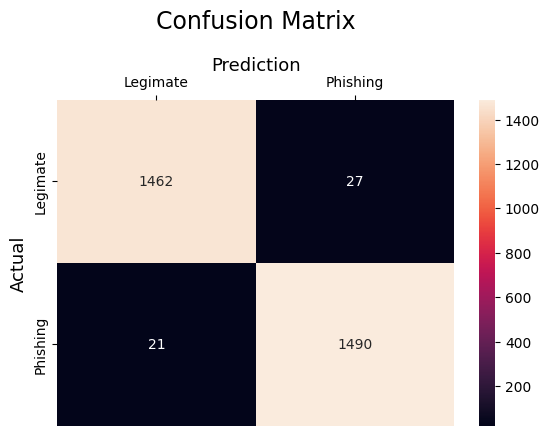

In [34]:
cm = confusion_matrix(y_test, stack_pred)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Legimate', 'Phishing'],
            yticklabels=['Legimate', 'Phishing'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

## ROC Curve & PR Curve

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


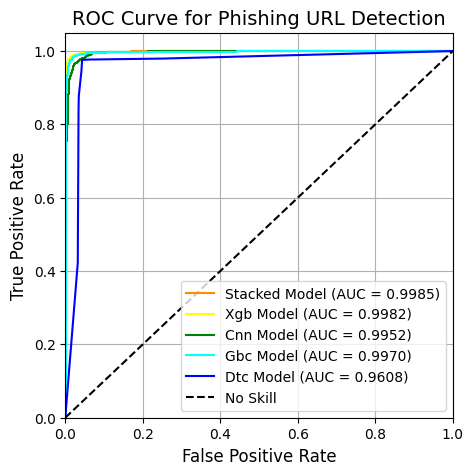

In [36]:
y_prob_stack = stack_model.predict_proba(stacked_test)[:, 1]
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_prob_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)
y_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
y_prob_cnn = cnn_model.predict(x_test_cnn)
y_prob_cnn = y_prob_cnn.ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
y_prob_gbc = gbc_pipe.predict_proba(x_test)[:, 1]
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, y_prob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
y_prob_dtc = dtc_pipe.predict_proba(x_test)[:, 1]
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, y_prob_dtc)
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

plt.figure(figsize=(5, 5))
plt.plot(fpr_stack, tpr_stack, label='Stacked Model (AUC = %0.4f)' % roc_auc_stack, color='darkorange')
plt.plot(fpr_xgb, tpr_xgb, label='Xgb Model (AUC = %0.4f)' % roc_auc_xgb, color='yellow')
plt.plot(fpr_cnn, tpr_cnn, label='Cnn Model (AUC = %0.4f)' % roc_auc_cnn, color='green')
plt.plot(fpr_gbc, tpr_gbc, label='Gbc Model (AUC = %0.4f)' % roc_auc_gbc, color='cyan')
plt.plot(fpr_dtc, tpr_dtc, label='Dtc Model (AUC = %0.4f)' % roc_auc_dtc, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Phishing URL Detection', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

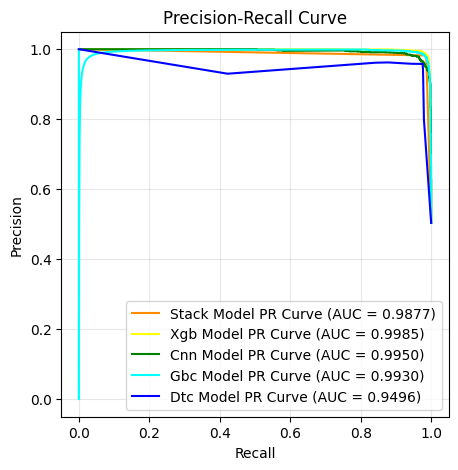

In [39]:
# Precision-Recall Curve
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_test, y_pred)
auc_score_stack = auc(recall_stack, precision_stack)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, xgb_probs)
auc_score_xgb = auc(recall_xgb, precision_xgb)
y_prob_cnn = cnn_model_test.ravel()
precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_test, y_prob_cnn)
auc_score_cnn = auc(recall_cnn, precision_cnn)
precision_gbc, recall_gbc, thresholds_gbc = precision_recall_curve(y_test, gbc_pipe_prob)
auc_score_gbc = auc(recall_gbc, precision_gbc)
precision_dtc, recall_dtc, thresholds_dtc = precision_recall_curve(y_test, dtc_pipe_prob)
auc_score_dtc = auc(recall_dtc, precision_dtc)

plt.figure(figsize=(5, 5))
plt.plot(recall_stack, precision_stack, label=f'Stack Model PR Curve (AUC = {auc_score_stack:.4f})', color='darkorange')
plt.plot(recall_xgb, precision_xgb, label=f'Xgb Model PR Curve (AUC = {auc_score_xgb:.4f})', color='yellow')
plt.plot(recall_cnn, precision_cnn, label=f'Cnn Model PR Curve (AUC = {auc_score_cnn:.4f})', color='green')
plt.plot(recall_gbc, precision_gbc, label=f'Gbc Model PR Curve (AUC = {auc_score_gbc:.4f})', color='cyan')
plt.plot(recall_dtc, precision_dtc, label=f'Dtc Model PR Curve (AUC = {auc_score_dtc:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

XGBoost contribution weight: 4.0694
CNN contribution weight: 2.9998
GradientBoosting contribution weight: 4.1335
DecisionTree contribution weight: 2.6950


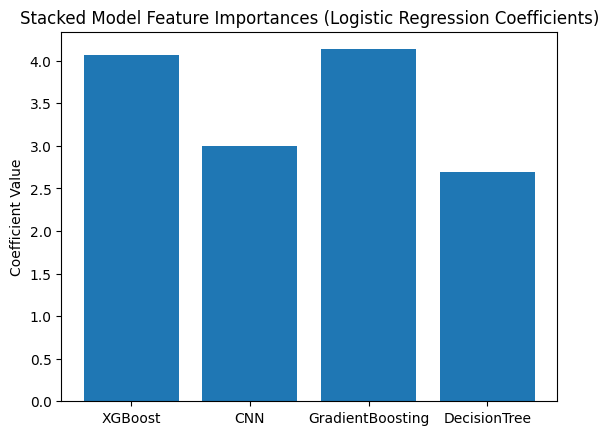

In [41]:
# Logistic Regression Coefficients
importance_scores = stack_model.coef_[0]
stacked_features = ['XGBoost', 'CNN', 'GradientBoosting', 'DecisionTree']
for name, coef in zip(stacked_features, importance_scores):
    print(f"{name} contribution weight: {coef:.4f}")

plt.bar(stacked_features, importance_scores)
plt.title('Stacked Model Feature Importances (Logistic Regression Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()

# Save Model

Saving Final XGB Model

In [ ]:
joblib.dump(xgb_model, 'xgb_model.pkl')

Saving Final CNN Complex Model

In [ ]:
cnn_model.save('cnn_complex.h5')

Saving Final Gradient Boosting Model

In [ ]:
joblib.dump(gbc_pipe, 'gbc_model.pkl')

Saving Final Decision Tree Model

In [ ]:
joblib.dump(dtc_pipe, 'dtc_model.pkl')